# Portfolio Optimization 

## Import Required Libraries

In [4]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install datetime

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install timedelta

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import yfinance as yf 
#This library is used to pick stock prices from website of Yahoo Finance
import pandas as pd
from datetime import datetime, timedelta
#datatime allows us select a certain time range
import numpy as np
from scipy.optimize import minimize
#NumPy and SciPy will allow us to use certain statistical methods that we need

# Section 1- Define Tickers and Time Range

## Define the list of tickers

In [ ]:
tickers = ['HDB','RELIANCE.NS','TCS.NS','SBIN.NS', 'AXB.IL']

## Set the end date to today

In [ ]:
end_date = datetime.today()
print(end_date)

## Set the start date to 5 years ago

In [22]:
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2018-11-30 09:21:31.764510


# Section 2 - Download Adjusted Closed Prices

## Create an empty DataFrame to store the adjusted close prices

In [23]:
adj_close_df = pd.DataFrame()

## Download the close prices for each ticker

In [24]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Display the DataFrame

In [25]:
print(adj_close_df)

                  HDB  RELIANCE.NS       TCS.NS     SBIN.NS     AXB.IL
Date                                                                  
2018-11-30  49.095390  1134.802368  1765.933472  272.418213  44.180496
2018-12-03  48.495129  1124.013916  1778.629272  274.475800  44.130688
2018-12-04  48.064297  1119.980225  1804.154907  270.408447  43.931450
2018-12-06  49.308380  1092.133911  1787.870483  263.804993  41.739864
2018-12-07  48.630669  1101.999268  1790.113770  263.565704  41.590435
...               ...          ...          ...         ...        ...
2023-11-21  58.849998  2378.899902  3510.199951  561.500000  59.200001
2023-11-22  58.639999  2388.199951  3530.149902  558.950012  59.700001
2023-11-24  59.500000  2393.899902  3457.100098  560.349976  60.599998
2023-11-27  58.889999          NaN          NaN         NaN  60.200001
2023-11-28  59.349998  2394.399902  3470.149902  564.450012  61.700001

[1256 rows x 5 columns]


# Section 3 - Calculate Lognormal Returns

## Calculate the lognormal returns for each ticker

In [26]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

## Drop any missing values

In [27]:
log_returns = log_returns.dropna()
print(log_returns)

                 HDB  RELIANCE.NS    TCS.NS   SBIN.NS    AXB.IL
Date                                                           
2018-12-03 -0.012302    -0.009552  0.007164  0.007525 -0.001128
2018-12-04 -0.008924    -0.003595  0.014249 -0.014930 -0.004525
2018-12-06  0.025554    -0.025178 -0.009067 -0.024723 -0.051174
2018-12-07 -0.013840     0.008993  0.001254 -0.000907 -0.003586
2018-12-10 -0.052940    -0.039168 -0.009771 -0.004367 -0.037833
...              ...          ...       ...       ...       ...
2023-11-17  0.006038    -0.002184  0.001314 -0.037645 -0.026404
2023-11-20  0.002234    -0.002636  0.004885  0.001242 -0.011775
2023-11-21  0.009904     0.012499 -0.002674 -0.003999  0.001691
2023-11-22 -0.003575     0.003902  0.005667 -0.004552  0.008410
2023-11-24  0.014559     0.002384 -0.020910  0.002501  0.014963

[1088 rows x 5 columns]


# Section 4 - Calculate Covariance Matrix

## Calculate the covariance matrix using annualized returns

In [28]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

                  HDB  RELIANCE.NS    TCS.NS   SBIN.NS    AXB.IL
HDB          0.117736     0.039472  0.019102  0.054027  0.080411
RELIANCE.NS  0.039472     0.093286  0.027346  0.041434  0.047385
TCS.NS       0.019102     0.027346  0.063284  0.021609  0.025122
SBIN.NS      0.054027     0.041434  0.021609  0.118086  0.088282
AXB.IL       0.080411     0.047385  0.025122  0.088282  0.182469


# Section 4 - Define Portfolio Performance Metrices

## Calculate the portfolio standard deviation

This line of code calculates the portfolio variance, which is a measure of risk associated with a portfolio of assets.  

In [29]:
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)    

## Calculate the expected return

In [30]:
def expected_return(weights,log_returns):
    return np.sum(log_returns.mean()*weights)*252

## Calculate the Sharpe Ratio

In [31]:
def sharpe_ratio(weights,log_returns, cov_matrix, risk_free_rate):
    return(expected_return(weights,log_returns)- risk_free_rate) / standard_deviation(weights,cov_matrix)

# Section 5 - Portfolio Optimization

## Set the Risk-free rate

In [32]:
risk_free_rate = 0.07 

## Define the function to minimize (negative Sharpe Ratio)

In [34]:
def neg_sharpe_ratio(weights,log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights,log_returns, cov_matrix, risk_free_rate)
    

## Set the Constraints and Bounds 

In [41]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

## Set the Initial Weights 

In [36]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print (initial_weights) 

[0.2 0.2 0.2 0.2 0.2]


##  Optimize the weights to maximize sharpe ratio

In [38]:
optimized_results = minimize(neg_sharpe_ratio,initial_weights, args =(log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bounds)

## Get the Optimal Weights

In [39]:
optimal_weights = optimized_results.x

## Section 7 - Analyze the optimal Portfolio

## Display the analytics of the portfolio

In [42]:
print('Optimal Weights')
for ticker, weight in zip(tickers,optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights
HDB: 0.0000
RELIANCE.NS: 0.2000
TCS.NS: 0.4000
SBIN.NS: 0.4000
AXB.IL: 0.0000
Expected Annual Return: 0.1571
Expected Volatility: 0.2251
Sharpe Ratio: 0.3868


## Display the final portfolio as a plot

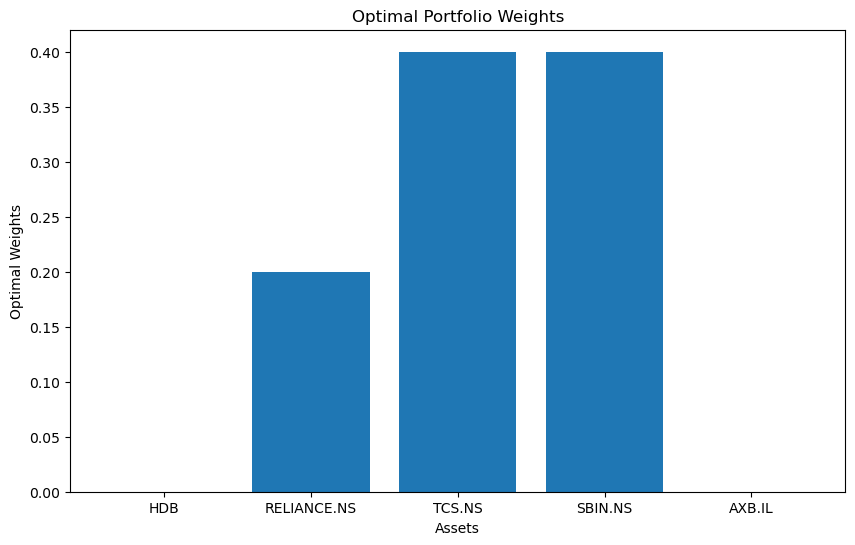

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

## Happy Coding